In [2]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import pandas_datareader as web
import datetime as dt

from sklearn.preprocessing import MinMaxScaler
from tensorflow.keras.layers import Dense, Dropout, LSTM
from tensorflow.keras.models import Sequential

In [3]:
prediction_days = 60
future_days = 30

In [6]:
x_train, y_train = [], []

pred_crypto_currencies = ['ETH', 'LTC', 'DOGE', 'BNB', 'USDT', 'USDC', 'SAND', 'UST']
against_currency = 'USD'

start = dt.datetime(2016, 1, 1)
end = dt.datetime.now()

scaler = MinMaxScaler(feature_range=(0,1))

for currency in pred_crypto_currencies:
    data = web.DataReader(f'{currency}-{against_currency}', 'yahoo', start, end)
    scaled_data = scaler.fit_transform(data['Close'].values.reshape(-1,1))
    for x in range(prediction_days, len(scaled_data)-future_days):
        x_train.append(scaled_data[x-prediction_days:x, 0])
        y_train.append(scaled_data[x:x+future_days, 0])

In [7]:
x_train, y_train = np.array(x_train), np.array(y_train)

In [8]:
x_train = np.reshape(x_train, (x_train.shape[0], x_train.shape[1], 1))
y_train = np.reshape(y_train, (y_train.shape[0], y_train.shape[1], 1))

In [16]:
try:    
    from tensorflow import keras
    model = keras.models.load_model('./modelsave/model1/')
except:
    print('loading model has been unsuccesful, training model will start automaticly)')
    model = Sequential()

    model.add(LSTM(units=50, return_sequences=True, input_shape=(x_train.shape[1], 1)))
    model.add(Dropout(0.2))
    model.add(LSTM(units=50, return_sequences=True))
    model.add(Dropout(0.2))
    model.add(LSTM(units=50))
    model.add(Dropout(0.2))
    model.add(Dense(units=future_days))

    model.compile(optimizer='adam', loss='mean_squared_error')
    model.fit(x_train, y_train, epochs=25, batch_size=32)

    model.save('./modelsave/model1')

loading model has been unsuccesful, training model will start automaticly)
Epoch 1/25
320/320 [==============================] - 35s 84ms/step - loss: 0.0143
Epoch 2/25
320/320 [==============================] - 28s 87ms/step - loss: 0.0075
Epoch 3/25
320/320 [==============================] - 29s 91ms/step - loss: 0.0065
Epoch 4/25
320/320 [==============================] - 29s 91ms/step - loss: 0.0062
Epoch 5/25
320/320 [==============================] - 29s 92ms/step - loss: 0.0059
Epoch 6/25
320/320 [==============================] - 29s 90ms/step - loss: 0.0058
Epoch 7/25
320/320 [==============================] - 29s 90ms/step - loss: 0.0056
Epoch 8/25
320/320 [==============================] - 29s 91ms/step - loss: 0.0056
Epoch 9/25
320/320 [==============================] - 30s 93ms/step - loss: 0.0055
Epoch 10/25
320/320 [==============================] - 29s 90ms/step - loss: 0.0055
Epoch 11/25
320/320 [==============================] - 29s 91ms/step - loss: 0.0054
Epoch 12/2

INFO:tensorflow:Assets written to: ./modelsave/model1\assets


INFO:tensorflow:Assets written to: ./modelsave/model1\assets


# Testing

In [27]:
test_start = dt.datetime(2020,1,1)
test_end = dt.datetime.now()

test_crypto_currency = 'BTC'
test_data = web.DataReader(f'{test_crypto_currency}-{against_currency}', 'yahoo', test_start, test_end)

np_test_data = np.array(test_data['Close'].values.reshape(-1,1))
scaled_test_data = scaler.fit_transform(test_data['Close'].values.reshape(-1,1))

In [28]:
x_test, y_test = [], []

for x in range(prediction_days, len(scaled_test_data)-future_days):
    x_test.append(scaled_test_data[x-prediction_days:x, 0])
    y_test.append(np_test_data[x-future_days:x, 0])

In [29]:
x_test, y_test = np.array(x_test), np.array(y_test)

In [30]:
x_test = np.reshape(x_test, (x_test.shape[0], x_test.shape[1], 1))

In [31]:
prediction = model.predict(x_test)
prediction_price = scaler.inverse_transform(prediction)

score = abs(prediction_price-y_test)

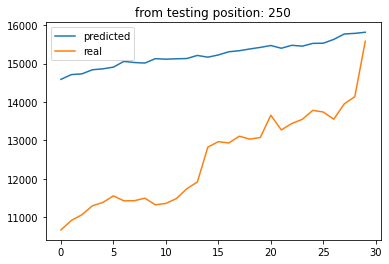

In [32]:
n_day = 250
plt.plot(prediction_price[n_day],label='predicted')
plt.plot(y_test[n_day], label='real')
plt.title('from testing position: '+str(n_day))
plt.legend()
plt.show()

Spearmans correlation: 0.964


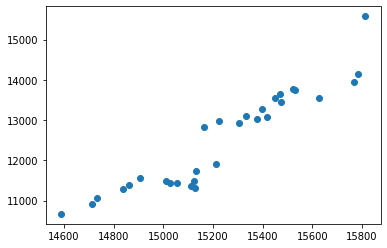

In [33]:
plt.scatter(prediction_price[n_day], y_test[n_day])
from scipy.stats import spearmanr
corr, _ = spearmanr(prediction_price[n_day], y_test[n_day])
print('Spearmans correlation: %.3f' % corr)

In [34]:
correlation = []
for i in range(prediction_price.shape[0]):
    corr, _ = spearmanr(prediction_price[i], y_test[i])
    correlation.append(corr)

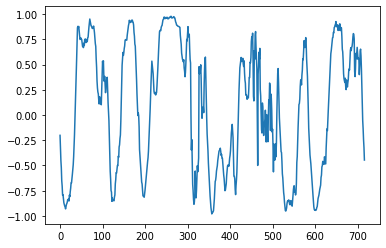

In [35]:
plt.plot(correlation)

In [36]:
np.mean(correlation)

0.08429135151126263

(array([ 85.,  65.,  74.,  47.,  39.,  49.,  72.,  85.,  85., 116.]),
 array([-9.79532814e-01, -7.83759733e-01, -5.87986652e-01, -3.92213571e-01,
        -1.96440489e-01, -6.67408231e-04,  1.95105673e-01,  3.90878754e-01,
         5.86651835e-01,  7.82424917e-01,  9.78197998e-01]),
 <BarContainer object of 10 artists>)

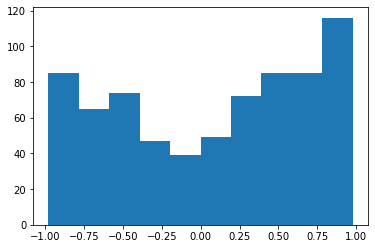

In [37]:
plt.hist(correlation)